<h1>Quantifying the Best Spot to Start a Hip Bar in Copenhagen</h1>

<h3>Business Problem</h3>
<h4>Problem</h4><br>
A local Danish businessman wants to open a hip coffee shop to take advantage of the artisanal coffee trend. As coffee shops are plentiful and have low start up costs the businessman wants to open the coffee shop in an area that doesnt have a high density of coffee shops. The businessman would also prefer to place the shop in a neighborhood with a growing population of adults in the age bracket 20 - 44 as the businessman believes this group is most likely to have a higher percentage of spending money and more interested in exploring high quality coffee. The businessman would ideally like to have a foothold in the market by 2022.

<h4>The Data</h4><br>
We will be using a series of openly available datasets to solve the problem.The first 3 are curated by the Municipality of Copenhagen. Bing API is free to use for multiple geocoding per day. The last is owned by Foursquare and restricted to the free tier level for this report.<br>

1. [**Danish Neighborhoods GeoJson:**](https://www.opendata.dk/city-of-copenhagen/bydele#resource-bydele.geojson) Used to segregate the neighborhoods of Copenhagen  
2. [**Spending Income per household:**](https://statistikbanken.kk.dk/0fe2c760-11e2-48a6-8963-dd165cd9b7bf/ReportSection9f156f02d7d01d570671) To find the neighborhoods with the highest available spending money and highest growing spending money.
3. [**Population Data:**](https://statistikbanken.kk.dk/377959c6-6b78-457f-af77-f3f5f038f397/ReportSection8528a94a84d7d309e743)  To explore which neighborhoods has the highest growing population of our target audience
4. [**Bing API:**](https://www.bingmapsportal.com/)  To find the latitude & longitude of the center of our chosen neighborhoods
4. [**Foursquare API:**](https://foursquare.com/developers/apps)  To catalog existing number of coffee shops to decide where we have the weakest competition


<h3>Methodology</h3>

Importing relevant packages to scrape and data clean our sources.

In [50]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests as rq
from IPython.display import HTML, display
import json
import geojson

First, I scrape the official neighborhoods of Copenhagen from the geojson file and their ID numbers to later join it with the population data. I have chosen not to use the multi-polygon coordinates and instead have utilized the Bing maps API to find the center of the neighborhoods.

In [51]:
url='https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:bydel&outputFormat=json&SRSNAME=EPSG:4326'
html=rq.get(url).json()
bydel=[]
idnum=[]

#html['features'][0]['properties']['navn']

for x in range(0,len(html['features'])):
    bydel.append(html['features'][x]['properties']['navn'])
    idnum.append(html['features'][x]['properties']['id'])

df=pd.DataFrame(list(zip(idnum,bydel)),columns=['id','area'])
df.replace(to_replace=['Brønshøj-Husum','Vesterbro-Kongens Enghave'],value=['Brønshøj','Vesterbro'],inplace=True)
df

,id,area
0,9,Amager Øst
1,1,Indre By
2,2,Østerbro
3,3,Nørrebro
4,7,Brønshøj
5,8,Bispebjerg
6,6,Vanløse
7,10,Amager Vest
8,5,Valby
9,4,Vesterbro


Install geocoder to get latitude and longitude coordinates for our neighborhoods

In [52]:
!pip install --user geocoder

Import the geocoder package to our notebook

In [53]:
import geocoder

Supply our Bing API credentials for use in geocoder. My credentials are hidden in below cell

In [54]:
# The code was removed by Watson Studio for sharing.

Run a for loop over our neighborhoods pushing lat and long to seperate lists which are then appended to our dataframe.

In [55]:
lati=np.zeros(10)
longi=np.zeros(10)

for i,a in enumerate(df['area']):
    g=geocoder.bing('{}, Copenhagen'.format(a),key=bingcred)
    lati[i]=g.lat
    longi[i]=g.lng
    
df['Lat']=lati
df['Long']=longi
df.head()

,id,area,Lat,Long
0,9,Amager Øst,55.675758,12.569023
1,1,Indre By,55.680000,12.580000
2,2,Østerbro,55.709209,12.577404
3,3,Nørrebro,55.694340,12.548649
4,7,Brønshøj,55.704823,12.496385


Bing cant get the right coordinates for Amager Øst so I manually clean that data point.

In [56]:
df['Lat'][0]=55.665629
df['Long'][0]=12.613326

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Now we move on to our foursquare analysis of venues in each neighborhood. My API details are in the below hidden cell.

In [57]:
# The code was removed by Watson Studio for sharing.

Finally, I have queried the Foursquare API to create a custom data set of venues in the category coffee shops within 750 meters of the neighborhood center. 750 meters was chosen as the overall total diameter of Copenhagen is ~10km. With 10 different neighborhoods that would leave ~1 km per neighborhood, but to avoid overlaps of venues I decreased that by 25%. With the venue data set I transformed it into a count of venue types per neighborhood.<br><br>
I run a for loop to pull all venues within our limits and create a new dataframe with our results

In [58]:
# create the API request URL
venues_list=[]
radius=750
limit=100
catid='4bf58dd8d48988d1e0931735'

for name, lat, lng in zip(df['area'], df['Lat'], df['Long']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        limit,
        catid
    )
    
    #make the GET request
    results = rq.get(url).json()["response"]['groups'][0]['items']

    venues_list.append([(
        name, 
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    coffee=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    coffee.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']

coffee.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amager Øst,55.665629,12.613326,Boheme Kaffebar,55.664707,12.604984,Coffee Shop
1,Amager Øst,55.665629,12.613326,Riccos Kaffebar,55.665209,12.607544,Coffee Shop
2,Amager Øst,55.665629,12.613326,Cub Coffee Bar,55.663970,12.622713,Coffee Shop
3,Amager Øst,55.665629,12.613326,Café A,55.663456,12.605977,Café
4,Amager Øst,55.665629,12.613326,Café A,55.664309,12.622563,Café


Lets explore how many venues are in each neighborhood using the groupby function. We can see Indre By has quite a few, followed by Vesterbro with 74. The rest are quite a bit below this level

In [59]:
cofgroup=coffee[['Neighborhood','Venue Category']].groupby(by='Neighborhood').count()
cofgroup

,Venue Category
Neighborhood,
Amager Vest,2
Amager Øst,5
Bispebjerg,3
Brønshøj,5
Indre By,100
Nørrebro,28
Valby,11
Vanløse,4
Vesterbro,74


Lets see how many types of shops qualify as coffee shops under the foursquare category coffee shops.

In [60]:
coffee['Venue Category'].unique()

array(['Coffee Shop', 'Café', 'Tea Room'], dtype=object)

I now create new columns for each type of venue and sum the number of venues per neighborhood for our final dataframe.

In [61]:
targets=['Coffee Shop','Café','Tea Room']
#temp=coffee[['Neighborhood','Venue Category']].loc[coffee['Venue Category']=='Coffee Shop'].groupby(by='Neighborhood').count()
#temp.head()
co1=df
#co1.columns = ['Coffee Shop' if x=='Venue Category' else x for x in co1.columns]

for tar in targets:
    
    temp=coffee[['Neighborhood','Venue Category']].loc[coffee['Venue Category']==tar].groupby(by='Neighborhood').count()
    co1=co1.join(temp,on='area')
    co1.columns = [tar if x=='Venue Category' else x for x in co1.columns]

co1=co1.fillna(0)
co1.sort_values(by=['id']).head(10)

,id,area,Lat,Long,Coffee Shop,Café,Tea Room
1,1,Indre By,55.680000,12.580000,28.0,69,3.0
2,2,Østerbro,55.709209,12.577404,3.0,13,0.0
3,3,Nørrebro,55.694340,12.548649,14.0,14,0.0
9,4,Vesterbro,55.672199,12.555000,27.0,46,1.0
8,5,Valby,55.666290,12.514337,5.0,6,0.0
6,6,Vanløse,55.690086,12.489993,1.0,3,0.0
4,7,Brønshøj,55.704823,12.496385,3.0,2,0.0
5,8,Bispebjerg,55.716881,12.533979,0.0,3,0.0
0,9,Amager Øst,55.665629,12.613326,3.0,2,0.0
7,10,Amager Vest,55.641670,12.578060,1.0,1,0.0


Lets take a look at our other data sets. First up is our population numbers. below is a reference to my data set storage which will be hidden.

In [62]:
# The code was removed by Watson Studio for sharing.

Checking out the data set we will need to do some modifications to only look at our target audience of 20-44 year olds.

In [63]:
pop.head()

,id,bydel,group,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,1,Indre By,0-4 år,2770,2793.302056,2802.648020,2856.816204,2934.397494,2999.744700,3056.440487,3100.327947,3141.096345,3181.005761,3242.214155,3294.980647,3336.687271,3372.783830,3406.002732,3438.000101
1,1,Indre By,5-9 år,2038,2009.421427,2008.469419,2013.222400,2019.793113,2046.710145,2076.078107,2094.796892,2126.183277,2177.923687,2244.559661,2308.646846,2371.263325,2431.897737,2487.859580,2539.047527
2,1,Indre By,10-14 år,2053,2104.004285,2104.997507,2101.302048,2078.291743,2016.586339,1989.558703,1983.499796,1991.374613,2004.856295,2047.468334,2091.732573,2130.784780,2173.434259,2232.797483,2295.614457
3,1,Indre By,15-19 år,2379,2348.489087,2339.712403,2342.537117,2382.179826,2402.419774,2436.689936,2427.973744,2401.541843,2360.976295,2313.634114,2288.552190,2282.284374,2304.905232,2333.838655,2381.667048
4,1,Indre By,20-24 år,5959,5940.615904,5778.199504,5537.996386,5308.235398,5102.572528,4943.916714,4804.851327,4728.391447,4710.336478,4768.762561,4857.482561,4952.717040,5030.317333,5095.217744,5120.305853


Getting the different group names.

In [64]:
pop['group'].unique()

array(['0-4 år', '5-9 år', '10-14 år', '15-19 år', '20-24 år', '25-29 år',
       '30-34 år', '35-39 år', '40-44 år', '45-49 år', '50-54 år',
       '55-59 år', '60-64 år', '65-69 år', '70-74 år', '75-79 år',
       '80-84 år', '85-89 år', '90-94 år', '95- år'], dtype=object)

Summing the populations for each neighborhood in our targeted age range

In [65]:
ages=['20-24 år','25-29 år','30-34 år','35-39 år','40-44 år']
group=pop.loc[pop['group'].isin(ages)].groupby(by='bydel').sum().sort_values(by='2022',ascending=False)
group

,id,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
bydel,,,,,,,,,,,,,,,,,
Nørrebro,15,46556,46427.668216,46024.322302,45606.893593,45207.975046,44762.201714,44211.445249,43681.711582,43247.595407,42838.048074,42455.041115,42052.314742,41644.629428,41309.399142,40943.803875,40555.495387
Vesterbro,20,39656,40881.295230,42222.442244,44131.193711,45902.570312,47687.698442,49676.545785,51605.987195,53463.518883,55145.756973,56492.912156,57543.095458,58361.842067,58814.772618,58970.047627,58861.857141
Amager Vest,50,39648,40509.784328,42055.232397,43809.839723,45178.120526,46220.934274,47095.528737,47861.975399,48503.580413,49019.572208,49152.929413,49171.558795,49067.015771,48868.013843,48505.526423,48060.173822
Østerbro,10,36761,37098.265154,37320.935596,37444.110919,37393.014060,37828.418178,38011.091883,38308.148021,38536.834497,38826.496231,39233.190277,39698.563147,40156.073541,40539.615530,40862.024993,41132.088714
Valby,25,29774,30582.955249,31545.886441,31888.016041,32142.992907,32421.914859,32617.143693,32841.576193,33141.849888,33462.260739,33761.843788,33985.112439,34137.020555,34218.873392,34193.005108,33990.935603
Amager Øst,45,30932,31326.108664,31476.852800,31494.308062,31517.340923,31543.730066,31645.859600,31757.037296,31852.764078,32004.666492,32414.012720,32933.949885,33412.413514,33853.372628,34261.935535,34643.137897
Bispebjerg,40,30212,30373.500777,30457.652863,30425.009068,30331.434389,30088.401933,29896.375034,29754.639455,29607.369408,29487.446465,29364.731098,29216.538703,29043.181130,28844.072791,28597.785718,28326.497014
Indre By,5,25513,25730.439714,25754.266376,25733.845524,25632.847770,25458.915598,25329.010698,25234.298552,25198.034069,25243.911562,25540.145817,25886.366409,26250.625373,26629.149446,26976.704516,27302.477116
Vanløse,30,17812,17622.023099,17504.647390,17470.042115,17476.444390,17346.405641,17203.005548,17087.444232,17001.244280,16946.940564,16907.705920,16858.125962,16796.748462,16711.146345,16591.439191,16454.846410


We now add the 2021 and 2022 sums to our original dataframe where we are building our feature set. We can also calculate 2 new columns popgrowth, the population growth from 2021 to 2022, and shoppop, the number of coffee shops per population in 2022.

In [66]:
co2=co1.join(group[['2021','2022']],on='area')
co2['popgrowth']=co2['2022'].divide(co2['2021'])
co2['popgrowth']=co2['popgrowth']-1
co2['shoppop']=co2['Coffee Shop'].divide(co2['2022'])
co2['shoppop'].replace(np.inf,0,inplace=True)
co2

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop
0,9,Amager Øst,55.665629,12.613326,3.0,2,0.0,31326.108664,31476.852800,0.004812,0.000095
1,1,Indre By,55.680000,12.580000,28.0,69,3.0,25730.439714,25754.266376,0.000926,0.001087
2,2,Østerbro,55.709209,12.577404,3.0,13,0.0,37098.265154,37320.935596,0.006002,0.000080
3,3,Nørrebro,55.694340,12.548649,14.0,14,0.0,46427.668216,46024.322302,-0.008688,0.000304
4,7,Brønshøj,55.704823,12.496385,3.0,2,0.0,16584.450203,16430.912557,-0.009258,0.000183
5,8,Bispebjerg,55.716881,12.533979,0.0,3,0.0,30373.500777,30457.652863,0.002771,0.000000
6,6,Vanløse,55.690086,12.489993,1.0,3,0.0,17622.023099,17504.647390,-0.006661,0.000057
7,10,Amager Vest,55.641670,12.578060,1.0,1,0.0,40509.784328,42055.232397,0.038150,0.000024
8,5,Valby,55.666290,12.514337,5.0,6,0.0,30582.955249,31545.886441,0.031486,0.000158
9,4,Vesterbro,55.672199,12.555000,27.0,46,1.0,40881.295230,42222.442244,0.032806,0.000639


Time to dive into the final dataset. Disposable income. We grab the most recent average disposable income from the dataset in 2017 and add to our original dataframe. Our feature set is now complete!

In [67]:

body = client_1fa3fed502ee4ea9a286a7e5b59ac833.get_object(Bucket='ibmdatascienceprofessionalcapston-donotdelete-pr-zqc9she6tsbghx',Key='disposable.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

income = pd.read_csv(body,index_col='id')
co3=co2.join(income['2017'],on='id')
co3.rename(columns={'2017':'disposable'},inplace=True)
co3

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable
0,9,Amager Øst,55.665629,12.613326,3.0,2,0.0,31326.108664,31476.852800,0.004812,0.000095,434663
1,1,Indre By,55.680000,12.580000,28.0,69,3.0,25730.439714,25754.266376,0.000926,0.001087,573470
2,2,Østerbro,55.709209,12.577404,3.0,13,0.0,37098.265154,37320.935596,0.006002,0.000080,497101
3,3,Nørrebro,55.694340,12.548649,14.0,14,0.0,46427.668216,46024.322302,-0.008688,0.000304,373848
4,7,Brønshøj,55.704823,12.496385,3.0,2,0.0,16584.450203,16430.912557,-0.009258,0.000183,425950
5,8,Bispebjerg,55.716881,12.533979,0.0,3,0.0,30373.500777,30457.652863,0.002771,0.000000,363029
6,6,Vanløse,55.690086,12.489993,1.0,3,0.0,17622.023099,17504.647390,-0.006661,0.000057,468188
7,10,Amager Vest,55.641670,12.578060,1.0,1,0.0,40509.784328,42055.232397,0.038150,0.000024,459276
8,5,Valby,55.666290,12.514337,5.0,6,0.0,30582.955249,31545.886441,0.031486,0.000158,434942
9,4,Vesterbro,55.672199,12.555000,27.0,46,1.0,40881.295230,42222.442244,0.032806,0.000639,437472


K-Means clustering is an iterative unsupervised algorithm that clusters data points together based on their feature-set similarity. My expectation is that by running the algorithm on our chosen feature-set (# coffee shops, population of target ages, growth of target ages, shops/population, disposable income) the algorithm will cluster our neighborhoods together and hopefully find a neighborhood with high population growth, high income and few coffee shops to compete with.
After normalizing the feature-set via a standard scaler to avoid over-weighting features with larger nominal numbers I identify the correct number of total clusters. The methodology for this requires running the algorithm multiple times across the relevant range of clusters. The maximum clusters for the algorithm are n samples – 1.


In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features=['Coffee Shop','Café','Tea Room','2022','popgrowth','shoppop','disposable']
X=StandardScaler().fit_transform(co3[features])
X

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.53918977, -0.63597746, -0.43643578, -0.06264387, -0.25777484,
        -0.51211395, -0.21332304],
       [ 1.91167284,  2.42952541,  2.83683257, -0.65767685, -0.48428136,
         2.51966595,  2.22761135],
       [-0.53918977, -0.13268595, -0.43643578,  0.54502228, -0.18840873,
        -0.55773106,  0.88465517],
       [ 0.53918977, -0.08693217, -0.43643578,  1.44999806, -1.04462721,
         0.12633838, -1.28276064],
       [-0.53918977, -0.63597746, -0.43643578, -1.62711665, -1.07786856,
        -0.2453534 , -0.36654198],
       [-0.83329329, -0.59022369, -0.43643578, -0.16862   , -0.37676793,
        -0.80342968, -1.47301379],
       [-0.73525878, -0.59022369, -0.43643578, -1.51546999, -0.92648727,
        -0.62881505,  0.3762173 ],
       [-0.73525878, -0.68173124, -0.43643578,  1.03729317,  1.68537825,
        -0.73074984,  0.21949892],
       [-0.34312077, -0.45296237, -0.43643578, -0.05546577,  1.29694949,
        -0.31896596, -0.2084168 ],
       [ 1.81363833,  1.3771

I will use two metrics to determine which number of clusters is the most accurate clustering of our data, the silhouette score and the standard score measure from the k-means package. The standard score measures the average distance of the data points to its cluster center. Ideally, we want to minimize this number to ensure the cluster is as similar as possible. As number of clusters increase the distance minimizes but the generalness of the cluster diminishes, and we can draw fewer conclusions. When only using the standard score the “elbow method” is used to choose a cluster number based on when the entropy or distance gained by increasing cluster numbers increases less rapidly between clusters. This method has the drawback of being difficult to choose which cluster number is the one where entropy decreases enough to choose it. 
I have therefore supplemented with the silhouette score which measures how similar the objects in a cluster are to its own cluster compared with the other clusters. A higher score here is better.
<br><br>
Let’s look at the scores for the battle of the neighborhoods feature-set.


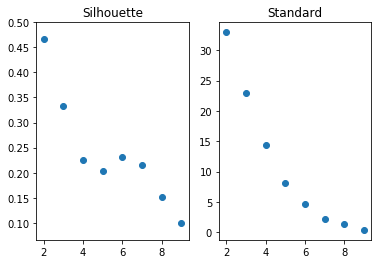

In [69]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

Cs=10
c_acc=np.zeros(8)
c_score=np.zeros(8)

for j,i in enumerate(range(2,Cs)):
    KMM=KMeans(n_clusters=i,random_state=10).fit(X)
    labels=KMM.labels_
    c_acc[j]=silhouette_score(X,labels)
    c_score[j]=abs(KMM.score(X))

fig=plt.figure()
plt.subplot(1,2,1)
plt.title('Silhouette')
plt.scatter(range(2,Cs),c_acc)
plt.subplot(1,2,2)
plt.title('Standard')
plt.scatter(range(2,Cs),c_score)
plt.show()

Settling our final Kmeans clustering algorithm and appending the cluster labels to our data set

In [70]:
finclus=6
KMMfin=KMeans(n_clusters=finclus,random_state=10).fit(X)
labels=KMMfin.labels_
co4=co3.copy()
co4['Labels']=labels
co4

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
0,9,Amager Øst,55.665629,12.613326,3.0,2,0.0,31326.108664,31476.852800,0.004812,0.000095,434663,5
1,1,Indre By,55.680000,12.580000,28.0,69,3.0,25730.439714,25754.266376,0.000926,0.001087,573470,1
2,2,Østerbro,55.709209,12.577404,3.0,13,0.0,37098.265154,37320.935596,0.006002,0.000080,497101,5
3,3,Nørrebro,55.694340,12.548649,14.0,14,0.0,46427.668216,46024.322302,-0.008688,0.000304,373848,4
4,7,Brønshøj,55.704823,12.496385,3.0,2,0.0,16584.450203,16430.912557,-0.009258,0.000183,425950,2
5,8,Bispebjerg,55.716881,12.533979,0.0,3,0.0,30373.500777,30457.652863,0.002771,0.000000,363029,5
6,6,Vanløse,55.690086,12.489993,1.0,3,0.0,17622.023099,17504.647390,-0.006661,0.000057,468188,2
7,10,Amager Vest,55.641670,12.578060,1.0,1,0.0,40509.784328,42055.232397,0.038150,0.000024,459276,0
8,5,Valby,55.666290,12.514337,5.0,6,0.0,30582.955249,31545.886441,0.031486,0.000158,434942,0
9,4,Vesterbro,55.672199,12.555000,27.0,46,1.0,40881.295230,42222.442244,0.032806,0.000639,437472,3


Cluster 5 doesn’t have very many coffee shops but has a mid-large population with the second highest disposable income. This is a strong sign. The detracting factor is that cluster 5 is not growing very much.<br><br>
Cluster 4 has negative population growth, a middling number of existing coffee shops and a relatively low disposable income.<br><br>
Cluster 3 has a lot of existing shops, high population and middling income but with the second strongest growth rate.<br><br>
Cluster 2 has few existing shops, middling disposable income, low population and a negative population growth.<br><br>
Cluster 1 has the highest disposable income a breakeven growth rate and the highest number of existing shops.<br><br>
Cluster 0 has high population, very few shops, middling income and the highest population growth.


In [71]:
co4.loc[co4['Labels']==0]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
7,10,Amager Vest,55.64167,12.578060,1.0,1,0.0,40509.784328,42055.232397,0.038150,0.000024,459276,0
8,5,Valby,55.66629,12.514337,5.0,6,0.0,30582.955249,31545.886441,0.031486,0.000158,434942,0


In [72]:
co4.loc[co4['Labels']==1]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
1,1,Indre By,55.68,12.58,28.0,69,3.0,25730.439714,25754.266376,0.000926,0.001087,573470,1


In [73]:
co4.loc[co4['Labels']==2]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
4,7,Brønshøj,55.704823,12.496385,3.0,2,0.0,16584.450203,16430.912557,-0.009258,0.000183,425950,2
6,6,Vanløse,55.690086,12.489993,1.0,3,0.0,17622.023099,17504.647390,-0.006661,0.000057,468188,2


In [74]:
co4.loc[co4['Labels']==3]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
9,4,Vesterbro,55.672199,12.555,27.0,46,1.0,40881.29523,42222.442244,0.032806,0.000639,437472,3


In [75]:
co4.loc[co4['Labels']==4]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
3,3,Nørrebro,55.69434,12.548649,14.0,14,0.0,46427.668216,46024.322302,-0.008688,0.000304,373848,4


In [76]:
co4.loc[co4['Labels']==5]

,id,area,Lat,Long,Coffee Shop,Café,Tea Room,2021,2022,popgrowth,shoppop,disposable,Labels
0,9,Amager Øst,55.665629,12.613326,3.0,2,0.0,31326.108664,31476.852800,0.004812,0.000095,434663,5
2,2,Østerbro,55.709209,12.577404,3.0,13,0.0,37098.265154,37320.935596,0.006002,0.000080,497101,5
5,8,Bispebjerg,55.716881,12.533979,0.0,3,0.0,30373.500777,30457.652863,0.002771,0.000000,363029,5


In [77]:
!pip install --user folium

For fun lets take a look at how these neighborhoods look on a folium map.

In [78]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import HTML, display

#Find toronto latitude+longitude
g=geocoder.bing('Copenhagen, Denmark',key=bingcred)
mapstart=[g.lat,g.lng]
#Initialize folium map object centered around Toronto
comap=folium.Map(location=mapstart,zoom_start=12,tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(finclus)
ys = [i + x + (i*x)**2 for i in range(finclus)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cof, pop in zip(co4['Lat'], co4['Long'], co4['area'], co4['Labels'], co4['Coffee Shop'],co4['popgrowth']):
    poppy=pop*100
    label = folium.Popup((
        '{pois}<br>'
        'Cluster: {clusters}<br>'
        'Coffee Shops: {cofs}<br>'
        'Ages 20-44 Pop Growth: {poppys}%').format(pois=str(poi),clusters=str(cluster),cofs=str(cof),poppys=str(poppy)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(comap)

In [79]:
HTML(comap._repr_html_())

Since K-Means is unsupervised there is no upfront explanation of the decision to allocate certain neighborhoods to certain clusters. Lets take a look at their characteristics visualized.

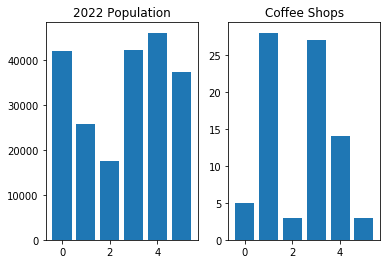

In [93]:
%matplotlib inline
clus0=len(co4.loc[co4['Labels']==0])
clus1=len(co4.loc[co4['Labels']==1])
clus2=len(co4.loc[co4['Labels']==2])
clus3=len(co4.loc[co4['Labels']==3])
clus4=len(co4.loc[co4['Labels']==4])
clus5=len(co4.loc[co4['Labels']==5])

plt.subplot(1,2,1)
plt.bar(co4['Labels'],co4['2022'])
plt.title('2022 Population')
plt.subplot(1,2,2)
plt.bar(co4['Labels'],co4['Coffee Shop'])
plt.title('Coffee Shops')
plt.show()

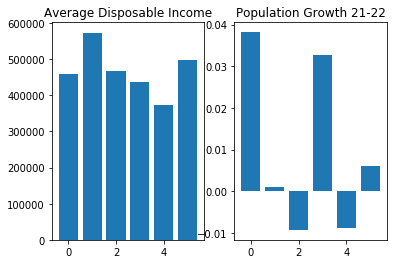

In [91]:
plt.subplot(1,2,1)
plt.bar(co4['Labels'],co4['disposable'])
plt.title('Average Disposable Income')
plt.subplot(1,2,2)
plt.bar(co4['Labels'],co4['popgrowth'])
plt.title('Population Growth 21-22')
plt.show()

Based on our data analysis we should dig further into Cluster 0 which has the strongest blend of our 4 characteristics.<br><br>
Amager Vest and Valby are the neighborhoods that are most similar as having a high disposable income, high population growth of the targeted age range and few existing coffee shops. The fictional businessman should focus on these two neighborhoods when looking for real estate to open the shop in. If those prove difficult the final top 5 ranking of neighborhoods is:
1.	Amager Vest
2.	Valby
3.	Vesterbro
4.	Amager Øst
5.	Østerbro
<br><br>

**Improvements**
The conclusion could be improved by spending more time on a couple of things. One element would be to add more data to the feature-set. For example, real estate pricing and average rating of the existing venues could add another decision layer to further cluster and select our target neighborhood. A one number comparison could simplify the ranking process instead of eye testing the features that best match up with the requirements.
